In [7]:
import seaborn as sns
import pandas as pd

df = sns.load_dataset("mpg")

print(df.shape)
print(df.info())
print(df.head())
print(df.describe())


(398, 9)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 398 entries, 0 to 397
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   mpg           398 non-null    float64
 1   cylinders     398 non-null    int64  
 2   displacement  398 non-null    float64
 3   horsepower    392 non-null    float64
 4   weight        398 non-null    int64  
 5   acceleration  398 non-null    float64
 6   model_year    398 non-null    int64  
 7   origin        398 non-null    object 
 8   name          398 non-null    object 
dtypes: float64(4), int64(3), object(2)
memory usage: 28.1+ KB
None
    mpg  cylinders  displacement  horsepower  weight  acceleration  \
0  18.0          8         307.0       130.0    3504          12.0   
1  15.0          8         350.0       165.0    3693          11.5   
2  18.0          8         318.0       150.0    3436          11.0   
3  16.0          8         304.0       150.0    3433          12.0

In [11]:
df.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,model_year,origin,name
0,18.0,8,307.0,130.0,3504,12.0,70,usa,chevrolet chevelle malibu
1,15.0,8,350.0,165.0,3693,11.5,70,usa,buick skylark 320
2,18.0,8,318.0,150.0,3436,11.0,70,usa,plymouth satellite
3,16.0,8,304.0,150.0,3433,12.0,70,usa,amc rebel sst
4,17.0,8,302.0,140.0,3449,10.5,70,usa,ford torino


Hur mycket drar bilarna (mpg)?

In [8]:
import matplotlib.pyplot as plt

# leta efter saknade värden
print(df.isnull().sum())

mpg             0
cylinders       0
displacement    0
horsepower      6
weight          0
acceleration    0
model_year      0
origin          0
name            0
dtype: int64


Horsepower har saknade värden.

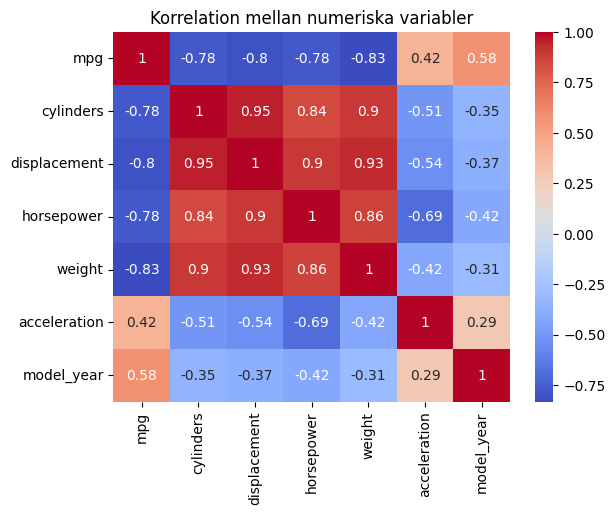

In [9]:
# korrelationer mellan numerska variabler
corr = df.corr(numeric_only=True)
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title("Korrelation mellan numeriska variabler")
plt.show()

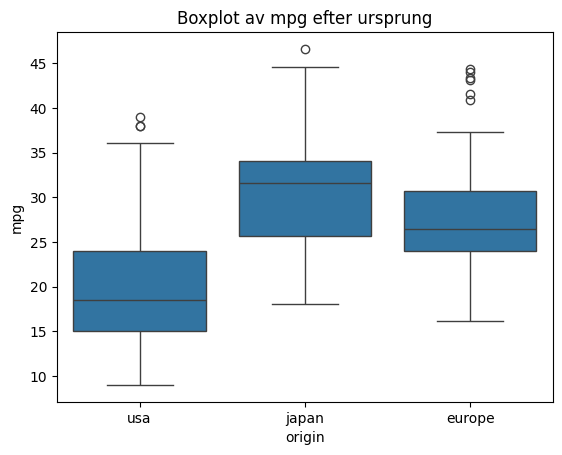

In [10]:
# Boxplot mpg vs origin (kategorisk)
sns.boxplot(x='origin', y='mpg', data=df)
plt.title("Boxplot av mpg efter ursprung")
plt.show()

- name är text, för många unika - ta bort
- origin är nominal, ej i ordning - one-hot-encoding

# Skapa pipeline

In [16]:
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.decomposition import PCA
from sklearn.compose import ColumnTransformer

# Features och target
X = df.drop(columns=['mpg', 'name'])  # ta bort name (text) och mpg (target)
y = df['mpg']


In [ ]:
# Kolumner
num_features = X.select_dtypes(include="number").columns.tolist()
cat_features = X.select_dtypes(include="object").columns.tolist()

# Transformers
num_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')), # ersätter saknade värden med medelvärde
    ('scaler', StandardScaler())
])

cat_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_transformer, num_features),
        ('cat', cat_transformer, cat_features)
    ]
)

# PCA för 80% varians
pca = PCA(n_components=0.8)

Träna modeller (med och utan PCA)

In [28]:
import time
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# utan PCA
model_no_pca = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("regressor", RandomForestRegressor(random_state=42))
])

# med PCA
model_pca = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("pca", PCA(n_components=0.8)),
    ("regressor", RandomForestRegressor(random_state=42))
])

# Träna och ta tid
start = time.time()
model_no_pca.fit(X_train, y_train)
time_no_pca = time.time() - start

start = time.time()
model_pca.fit(X_train, y_train)
time_pca = time.time() - start

# Prediktioner
y_pred_no_pca = model_no_pca.predict(X_test)
y_pred_pca = model_pca.predict(X_test)

# Accuracy (R2-score)
acc_no_pca = r2_score(y_test, y_pred_no_pca)
acc_pca = r2_score(y_test, y_pred_pca)

print(f"Utan PCA: R2={acc_no_pca:.3f}, Tid={time_no_pca:.3f} s")
print(f"Med PCA: R2={acc_pca:.3f}, Tid={time_pca:.3f} s")


Utan PCA: R2=0.914, Tid=0.239 s
Med PCA: R2=0.899, Tid=0.196 s


Visualisering av resultat

     Modell  R2-score  Träningstid (s)
0  Utan PCA  0.914092         0.239444
1   Med PCA  0.899351         0.196150


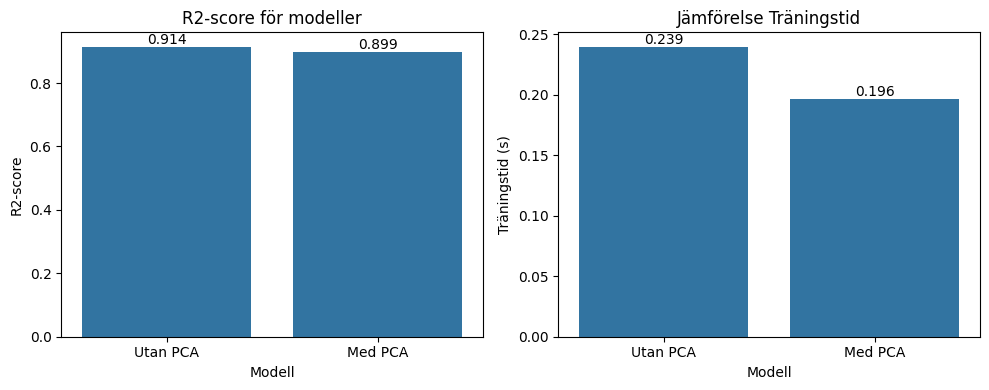

In [ ]:
import numpy as np

results = pd.DataFrame({
    "Modell": ["Utan PCA", "Med PCA"],
    "R2-score": [acc_no_pca, acc_pca],
    "Träningstid (s)": [time_no_pca, time_pca]
})

print(results)

# Barplots
fig, axes = plt.subplots(1, 2, figsize=(10, 4)) # subplot_kw=("projection": '3d')

bar1 = sns.barplot(data=results, x="Modell", y="R2-score", ax=axes[0])
axes[0].set_title("R2-score för modeller")
axes[0].bar_label(bar1.containers[0], fmt="%.3f")

bar2 = sns.barplot(data=results, x="Modell", y="Träningstid (s)", ax=axes[1])
axes[1].set_title("Jämförelse Träningstid")
axes[1].bar_label(bar2.containers[0], fmt="%.3f")

plt.tight_layout()
plt.show()


In [31]:
import time
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import r2_score, root_mean_squared_error

# Lista med modeller vi vill jämföra
models = {
    "Linear Regression": LinearRegression(),
    "SVR": SVR(kernel="rbf"),
    "kNN": KNeighborsRegressor(n_neighbors=5)
}

results = []

# Loopa över modellerna
for name, model in models.items():
    # Utan PCA
    pipe_no_pca = Pipeline(steps=[
        ("preprocessor", preprocessor),
        ("regressor", model)
    ])
    
    start = time.time()
    pipe_no_pca.fit(X_train, y_train)
    time_no_pca = time.time() - start
    
    y_pred_no_pca = pipe_no_pca.predict(X_test)
    r2_no_pca = r2_score(y_test, y_pred_no_pca)
    rmse_no_pca = root_mean_squared_error(y_test, y_pred_no_pca)
    
    results.append({
        "Model": name,
        "PCA": "Nej",
        "R2": r2_no_pca,
        "RMSE": rmse_no_pca,
        "Tid (s)": time_no_pca
    })
    
    # Med PCA
    pipe_pca = Pipeline(steps=[
        ("preprocessor", preprocessor),
        ("pca", PCA(n_components=0.8)),
        ("regressor", model)
    ])
    
    start = time.time()
    pipe_pca.fit(X_train, y_train)
    time_pca = time.time() - start
    
    y_pred_pca = pipe_pca.predict(X_test)
    r2_pca = r2_score(y_test, y_pred_pca)
    rmse_pca = root_mean_squared_error(y_test, y_pred_pca)
    
    results.append({
        "Model": name,
        "PCA": "Ja",
        "R2": r2_pca,
        "RMSE": rmse_pca,
        "Tid (s)": time_pca
    })

# Sammanställ i DataFrame
results_df = pd.DataFrame(results)
print(results_df)


               Model  PCA        R2      RMSE   Tid (s)
0  Linear Regression  Nej  0.844902  2.887740  0.019353
1  Linear Regression   Ja  0.815294  3.151349  0.014761
2                SVR  Nej  0.874344  2.599247  0.017816
3                SVR   Ja  0.860285  2.740797  0.014165
4                kNN  Nej  0.901826  2.297490  0.008067
5                kNN   Ja  0.885500  2.481181  0.001909


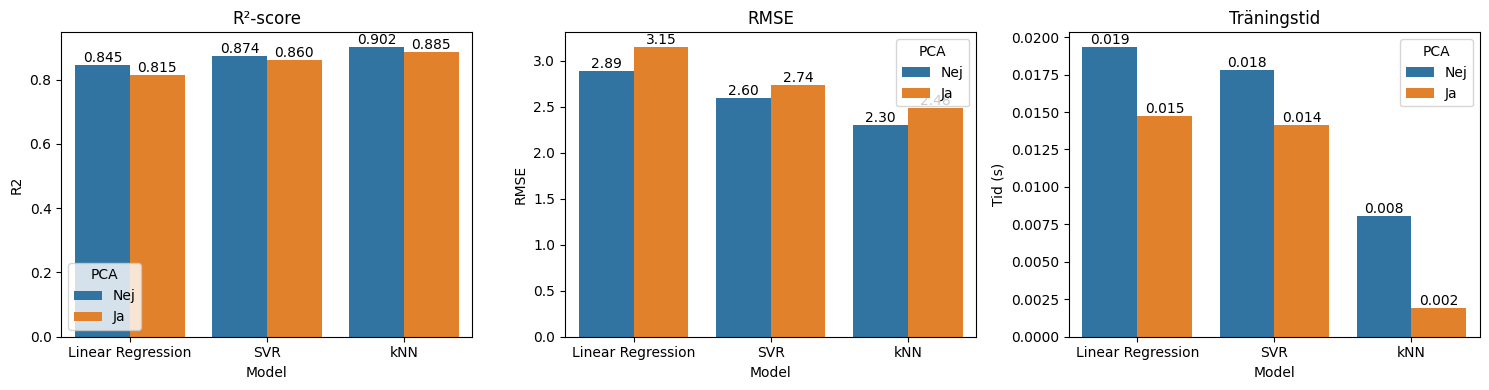

In [32]:
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# R2-score
sns.barplot(data=results_df, x="Model", y="R2", hue="PCA", ax=axes[0])
axes[0].set_title("R²-score")
axes[0].bar_label(axes[0].containers[0], fmt="%.3f")
axes[0].bar_label(axes[0].containers[1], fmt="%.3f")

# RMSE
sns.barplot(data=results_df, x="Model", y="RMSE", hue="PCA", ax=axes[1])
axes[1].set_title("RMSE")
axes[1].bar_label(axes[1].containers[0], fmt="%.2f")
axes[1].bar_label(axes[1].containers[1], fmt="%.2f")

# Tid
sns.barplot(data=results_df, x="Model", y="Tid (s)", hue="PCA", ax=axes[2])
axes[2].set_title("Träningstid")
axes[2].bar_label(axes[2].containers[0], fmt="%.3f")
axes[2].bar_label(axes[2].containers[1], fmt="%.3f")

plt.tight_layout()
plt.show()
